## Project Overview
Global Terrorism Database https://www.start.umd.edu/gtd/ has the largest unclassified data collection about terror attackes.  Many incidents however, have not been successfully associated with any terror groups. 

I am trying to use existing variables about the terror attacks and environmental variables to make smart guesses on these unidentified incidents, are they likely carried out by a known terror groups? Or from other groups never identified in the GTD database?

In [1]:
# !pip install xlrd
%matplotlib inline

import pandas, numpy, xlrd, seaborn, math
from matplotlib import pyplot
from sklearn.neighbors import KNeighborsClassifier, DistanceMetric
from sklearn.preprocessing import Imputer
from sklearn.metrics import accuracy_score

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
FILE_LOC = "/resources/data/Global Terrorism/global_terror.xlsx"
raw_data = pandas.read_excel(FILE_LOC)

## Data Cleanse
Based on Codebook, some metrics for some events are not available when they seemingly have a numeric value. It's better for feature selection if null values are counted right.

In [3]:
# Database and Additional Info
for itime in ['imonth', 'iday']: 
    raw_data.loc[raw_data[itime] == 0, itime] = None
for inter in ['INT_LOG', 'INT_IDEO', 'INT_MISC', 'INT_ANY']: 
    raw_data.loc[raw_data[inter] == -9, inter] = None

In [4]:
# Incident & Attack Info
raw_data.loc[raw_data['doubtterr'] == -9, 'doubtterr'] = None
for attack_id in range(3): 
    attack_type = 'attacktype' + str(attack_id + 1)
    raw_data.loc[raw_data[attack_type] == 9, attack_type] = None
for weapon_id in range(4): 
    weapon_type = 'weaptype' + str(weapon_id + 1)
    weapon_subtype = 'weapsubtype' + str(weapon_id + 1)
    raw_data.loc[raw_data[weapon_type] == 13, weapon_type] = None
    raw_data.loc[(raw_data[weapon_type] == 5) & (raw_data[weapon_subtype] == 5), weapon_subtype] = None
    raw_data.loc[(raw_data[weapon_type] == 6) & (raw_data[weapon_subtype] == 16), weapon_subtype] = None
    raw_data.loc[(raw_data[weapon_type] == 9) & (raw_data[weapon_subtype] == 27), weapon_subtype] = None

In [5]:
# Target & Casualty Info
for target_id in range(3): 
    target_type = 'targtype' + str(target_id + 1)
    raw_data.loc[raw_data[target_type] == 20, target_type] = None
for hostage in ['ishostkid', 'ransom']: 
    raw_data.loc[raw_data[hostage] == -9, hostage] = None
for hostage in ['nhostkid', 'nhostkidus', 'nreleased', 'nhours', 'ransomamt', 'ransomamtus', 'ransompaid', 'ransompaidus']: 
    raw_data.loc[raw_data[hostage] == -99, hostage] = None
raw_data.loc[raw_data['hostkidoutcome'] == 7, 'hostkidoutcome'] = None
raw_data.loc[raw_data['property'] == -9, 'property'] = None
raw_data.loc[raw_data['propextent'] == 4, 'propextent'] = None

In [6]:
# Perpetrator Info
for perpetrator in ['nperps', 'nperpcap']: 
    raw_data.loc[raw_data[perpetrator] == -99, perpetrator] = None
for claim_id in range(3): 
    claim_mode = 'claimmode'
    if claim_id >= 1: claim_mode += str(claim_id + 1)
    raw_data.loc[raw_data[claim_mode] == 10, claim_mode] = None
raw_data.loc[raw_data['compclaim'] == -9, 'compclaim'] = None
raw_data.loc[raw_data['claimed'] == -9, 'claimed'] = None

This analysis will not be very extensive and such columns will be excluded as
* descriptive text variables
* redundant categorical text variables
* columns with too many null values

In [7]:
descriptive_text = ['approxdate', 'summary', 'location', 'weapdetail', 'motive', 'propcomment', 'ransomnote', 'addnotes']
for target_id in range(3): 
    descriptive_text.append('corp' + str(target_id + 1))
    descriptive_text.append('target' + str(target_id + 1))
for source_id in range(3): 
    descriptive_text.append('scite' + str(source_id + 1))
descriptive_text.append('dbsource')
clean_data = raw_data.drop(descriptive_text, axis = 1)

In [8]:
redundant_category = ['alternative_txt', 'country_txt', 'region_txt', 'propextent_txt', 'hostkidoutcome_txt']
for attack_id in range(3): 
    redundant_category.append('attacktype' + str(attack_id + 1) + '_txt')
for weapon_id in range(4): 
    redundant_category.append('weaptype' + str(weapon_id + 1) + '_txt')
    redundant_category.append('weapsubtype' + str(weapon_id + 1) + '_txt')
for target_id in range(3): 
    redundant_category.append('targtype' + str(target_id + 1) + '_txt')
    redundant_category.append('targsubtype' + str(target_id + 1) + '_txt')
for nation_id in range(3): 
    redundant_category.append('natlty' + str(nation_id + 1) + '_txt')
for claim_id in range(3): 
    claim_mode = 'claimmode'
    if claim_id >= 1: claim_mode += str(claim_id + 1)
    redundant_category.append(claim_mode + '_txt')
clean_data = clean_data.drop(redundant_category, axis = 1)

In [9]:
many_nulls = []
null_count = clean_data.isnull().sum()
for index, value in null_count.iteritems(): 
    if value > 150000: 
        many_nulls.append(index)
clean_data = clean_data.drop(many_nulls, axis = 1)

## Exploratory Analysis
This analysis is trying to identify the terror groups for the unknown attacks, so we start with 'gname'
* dataset with unknown 'gname' split out for final prediction, the goal of this analysis
* dataset with identified 'gname' are for modeling, among which
* a subset of terror groups with relatively more records are for exploratory analysis

In [10]:
predict_data = clean_data[clean_data['gname'] == 'Unknown']
clean_data = clean_data[clean_data['gname'] != 'Unknown']
pyplot.rcParams["figure.figsize"] = [8, 12]

3289


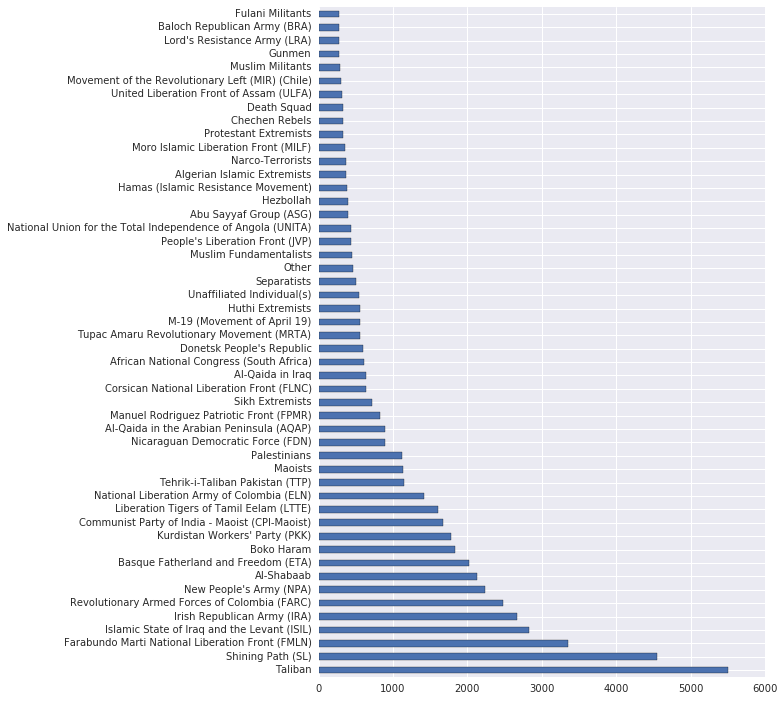

In [12]:
# incidents count by terror groups
print clean_data['gname'].value_counts().size
clean_data['gname'].value_counts()[:50].plot(kind='barh')

In [13]:
# Over 3000 groups in total, choose major 20 for exploratory section
major_group = clean_data['gname'].value_counts()[:20].index.tolist()
explore_data = clean_data[clean_data['gname'].isin(major_group)]
predict_data.shape, clean_data.shape, explore_data.shape

((71922, 56), (84850, 56), (42117, 56))

Next we manually assign other variables to subjective categories and apply visualizations to each of them, and promising features of a predictive models are those variables whose values look different across different terror groups. 
1. 'iyear', 'imonth', 'iday', 'region', 'country', 'provstate', 'city', 'latitude', 'longitude', 'vicinity'
0. 'crit1', 'crit2', 'crit3', 'doubtterr', 'alternative', 'claimed', 'claimmode'
0. 'targtype1', 'targsubtype1', 'targtype2', 'targsubtype2', 'natlty1', 'natlty2'
0. 'attacktype1', 'weaptype1', 'weapsubtype1', 'weaptype2', 'suicide', 'ishostkid', 'ransom'
0. 'nkill', 'nkillus', 'nwound', 'nwoundus', 'property', 'propextent', 'propvalue'
0. 'nperps', 'extended', 'multiple', 'nhostkid', 'nhostkidus'
0. 'nperpcap', 'nkillter', 'nwoundte', 'success'
0. 'INT_LOG', 'INT_IDEO', 'INT_MISC', 'INT_ANY'
0. (personal opinion that they are ambiguous or not easily useful) 'specificity', 'ingroup', 'related'

In [11]:
# many null values put a candidate variable as secondary feature
def over_view(explore_var): 
    print null_count[explore_var]
    return explore_data[explore_var].sample(20)

# visibly different distribution across terror groups put a candidate variable as a primary feature
# except those with a lot of unique values are put to secondary
def categorical_view(explore_var): 
    num_unique = explore_data[explore_var].nunique()
    print num_unique
    if num_unique < 200: 
        return seaborn.stripplot(x=explore_var, y='gname', data=explore_data, jitter=True)

# relatively larger difference in mean value across terror groups put a candiate variable as a primary feature
def numerical_view(explore_var): 
    return explore_data.groupby('gname')[explore_var].mean()

In [15]:
over_view(['INT_LOG', 'INT_IDEO', 'INT_MISC', 'INT_ANY'])

INT_LOG     84864
INT_IDEO    84989
INT_MISC      484
INT_ANY     76642
dtype: int64


,INT_LOG,INT_IDEO,INT_MISC,INT_ANY
17771,0.0,0.0,0.0,0.0
29257,0.0,0.0,1.0,1.0
1244,0.0,0.0,1.0,1.0
145157,0.0,1.0,0.0,1.0
67798,0.0,0.0,0.0,0.0
42569,0.0,0.0,0.0,0.0
156122,0.0,1.0,1.0,1.0
20425,0.0,0.0,0.0,0.0
29502,0.0,0.0,0.0,0.0
48699,0.0,0.0,0.0,0.0


73


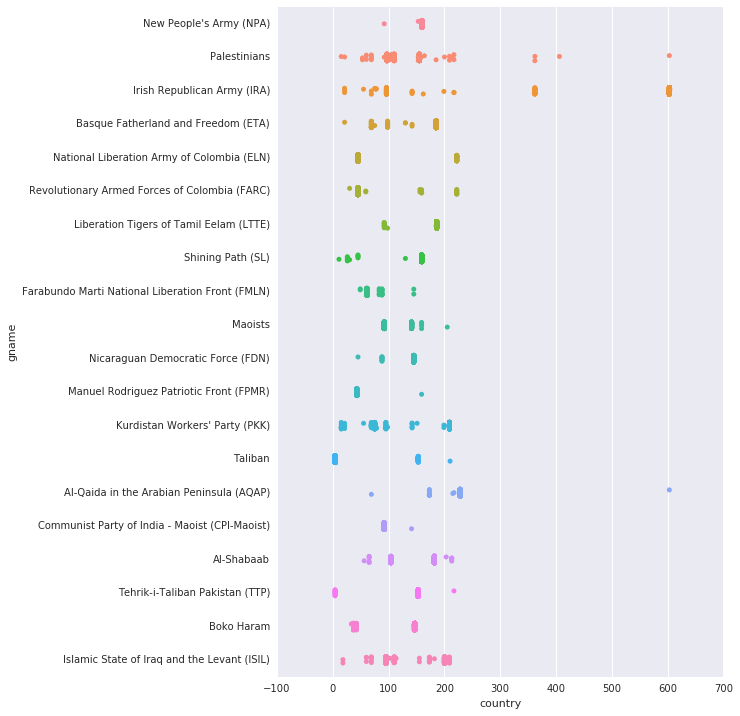

In [16]:
categorical_view('country')

In [17]:
numerical_view(['INT_LOG', 'INT_IDEO', 'INT_MISC', 'INT_ANY'])

,INT_LOG,INT_IDEO,INT_MISC,INT_ANY
gname,,,,
Al-Qaida in the Arabian Peninsula (AQAP),0.004479,1.000000,0.051512,1.000000
Al-Shabaab,0.132581,0.364534,0.239887,0.365005
Basque Fatherland and Freedom (ETA),0.010375,1.000000,0.104847,1.000000
Boko Haram,0.107123,0.117999,0.016857,0.118543
Communist Party of India - Maoist (CPI-Maoist),0.000600,0.006603,0.006002,0.006603
Farabundo Marti National Liberation Front (FMLN),0.006267,0.015522,0.011642,0.016119
Irish Republican Army (IRA),0.140449,0.024024,0.989489,1.000000
Islamic State of Iraq and the Levant (ISIL),0.179487,0.282051,0.024356,0.730769
Kurdistan Workers' Party (PKK),0.101010,0.030354,0.102305,0.115795


In [11]:
# From exploration above, some variables are used as primary
feature_primary = ['iyear', 'region', 'latitude', 'longitude', 'vicinity', 'crit3', 'doubtterr', 'claimed', 
                   'targtype1', 'attacktype1', 'weaptype1', 'weapsubtype1', 'suicide', 'ishostkid', 'extended', 'multiple', 
                   'nkill', 'nwound', 'property', 'nperpcap', 'nkillter', 'nwoundte', 'INT_LOG', 'INT_IDEO', 'INT_MISC']
feature_secondary = ['imonth', 'iday', 'country', 'provstate', 'city', 'crit1', 'crit2', 'alternative', 'claimmode', 
                     'targsubtype1', 'targtype2', 'targsubtype2', 'natlty1', 'natlty2', 'weaptype2', 'ransom', 'nkillus', 'nwoundus', 'propextent', 'propvalue', 
                     'nperps', 'nhostkid', 'nhostkidus', 'success', 'INT_ANY']

## Predictive Modeling
There are many terror groups on the record, and the distribution of incident counts have a long tail.  The target variable being a categorical one with many instances makes it difficult to implement most classification models like tree or regression, but a **nearest-neighbor** model probably works well

In [17]:
# training-testing split
split_marker = numpy.random.rand(len(clean_data)) < 0.75
train_data = clean_data[feature_primary + ['gname', 'eventid']][split_marker]
test_data = clean_data[feature_primary + ['gname', 'eventid']][~split_marker]
train_data.shape, test_data.shape

((63565, 27), (21285, 27))

In [18]:
# set up KNN model and Null value handling
train_data_trans = train_data.drop(['gname', 'eventid'], axis=1)
test_data_trans = test_data.drop(['gname', 'eventid'], axis=1)

processor = Imputer(missing_values='NaN', strategy='mean', axis=0)
classifier = KNeighborsClassifier(weights='distance')

Most distance metrics assume uniform weight on different variables, but we have a variety of variables, and difference in target type of attach type is more likely to associate with the unique identity of particular terror groups, than 1 degree difference in latitude or longitude. 

A custom distance function can include weights, but rescaling input variables has equivalent effect while makes computation lighter.  above two functions are doing this, in addition to handling categorical variables

In [12]:
categorical_primary = ['region', 'targtype1', 'attacktype1', 'weaptype1', 'weapsubtype1']
numerical_primary = [feature for feature in feature_primary if feature not in categorical_primary]

# break down categorical variables into dummy variables to enable "distance" calculation
def transform_categorical(data_set, var_name, scale): 
    dummy_var = pandas.get_dummies(data_set[var_name], columns=[var_name], prefix=var_name)
    return pandas.concat([data_set.drop(var_name, axis=1), dummy_var * scale], axis=1)
    
def transform_numerical(data_set, var_name, scale): 
    output = data_set
    output[var_name] = data_set[var_name] * scale
    return output

In [22]:
# base-line KNN model with uniform weight, 72% accuracy
for pos in range(len(categorical_primary)): 
    train_data_trans = transform_categorical(train_data_trans, categorical_primary[pos], 1)
    test_data_trans = transform_categorical(test_data_trans, categorical_primary[pos], 1)
X = processor.fit(train_data_trans).transform(train_data_trans)
y = train_data['gname']
classifier.fit(X, y)
test_data['gname_predict'] = classifier.predict(processor.fit(train_data_trans).transform(test_data_trans))
print accuracy_score(test_data['gname'], test_data['gname_predict'])
test_data.drop(['gname_predict'], axis=1, inplace=True)

0.725614101772


Improve the predictive model in 2 ways
1. non-uniform weights assigned to different variables, and here I choose a simplified method to find better weights one-by-one
2. find the best combination among several of parameters used in KNN classifer

In [23]:
# 5 categorical variables
for pos in range(len(categorical_primary)): 
    for weight in [0.1, 0.5, 2, 10]: 
        train_data_trans = train_data.drop(['gname', 'eventid'], axis=1)
        test_data_trans = test_data.drop(['gname', 'eventid'], axis=1)
        for i in range(len(categorical_primary)): 
            if i == pos: 
                train_data_trans = transform_categorical(train_data_trans, categorical_primary[i], weight)
                test_data_trans = transform_categorical(test_data_trans, categorical_primary[i], weight)
            else: 
                train_data_trans = transform_categorical(train_data_trans, categorical_primary[i], 1)
                test_data_trans = transform_categorical(test_data_trans, categorical_primary[i], 1)
        X = processor.fit(train_data_trans).transform(train_data_trans)
        y = train_data['gname']
        classifier.fit(X, y)
        test_data['gname_predict'] = classifier.predict(processor.fit(train_data_trans).transform(test_data_trans))
        test_accuracy = accuracy_score(test_data['gname'], test_data['gname_predict'])
        test_data.drop(['gname_predict'], axis=1, inplace=True)
        print '{0} {1} {2:.3f}'.format(categorical_primary[pos], weight, test_accuracy)

region 0.1 0.723
region 0.5 0.724
region 2 0.729
region 10 0.731
targtype1 0.1 0.724
targtype1 0.5 0.725
targtype1 2 0.717
targtype1 10 0.697
attacktype1 0.1 0.727
attacktype1 0.5 0.727
attacktype1 2 0.721
attacktype1 10 0.714
weaptype1 0.1 0.727
weaptype1 0.5 0.726
weaptype1 2 0.723
weaptype1 10 0.718
weapsubtype1 0.1 0.725
weapsubtype1 0.5 0.725
weapsubtype1 2 0.721
weapsubtype1 10 0.710


In [24]:
weight = {'region': 10, 'targtype1': 0.5, 'attacktype1': 0.1, 'weaptype1': 0.5, 'weapsubtype1': 0.1}
for pos in range(len(categorical_primary)): 
    curr_feature = categorical_primary[pos]
    train_data = transform_categorical(train_data, curr_feature, weight[curr_feature])
    test_data = transform_categorical(test_data, curr_feature, weight[curr_feature])

In [25]:
# 20 numerical variables
for pos in range(len(numerical_primary)): 
    for weight in [0.1, 0.5, 2, 10]: 
        train_data_trans = train_data.drop(['gname', 'eventid'], axis=1)
        test_data_trans = test_data.drop(['gname', 'eventid'], axis=1)
        train_data_trans = transform_numerical(train_data_trans, numerical_primary[pos], weight)
        test_data_trans = transform_numerical(test_data_trans, numerical_primary[pos], weight)
        X = processor.fit(train_data_trans).transform(train_data_trans)
        y = train_data['gname']
        classifier.fit(X, y)
        test_data['gname_predict'] = classifier.predict(processor.fit(train_data_trans).transform(test_data_trans))
        test_accuracy = accuracy_score(test_data['gname'], test_data['gname_predict'])
        test_data.drop(['gname_predict'], axis=1, inplace=True)
        print '{0} {1} {2:.3f}'.format(numerical_primary[pos], weight, test_accuracy)

iyear 0.1 0.701
iyear 0.5 0.728
iyear 2 0.731
iyear 10 0.728
latitude 0.1 0.706
latitude 0.5 0.727
latitude 2 0.734
latitude 10 0.729
longitude 0.1 0.699
longitude 0.5 0.726
longitude 2 0.736
longitude 10 0.728
vicinity 0.1 0.734
vicinity 0.5 0.734
vicinity 2 0.732
vicinity 10 0.730
crit3 0.1 0.734
crit3 0.5 0.734
crit3 2 0.733
crit3 10 0.731
doubtterr 0.1 0.734
doubtterr 0.5 0.734
doubtterr 2 0.732
doubtterr 10 0.733
claimed 0.1 0.731
claimed 0.5 0.732
claimed 2 0.732
claimed 10 0.732
suicide 0.1 0.734
suicide 0.5 0.734
suicide 2 0.733
suicide 10 0.733
ishostkid 0.1 0.734
ishostkid 0.5 0.734
ishostkid 2 0.734
ishostkid 10 0.733
extended 0.1 0.735
extended 0.5 0.735
extended 2 0.733
extended 10 0.733
multiple 0.1 0.732
multiple 0.5 0.732
multiple 2 0.733
multiple 10 0.731
nkill 0.1 0.747
nkill 0.5 0.740
nkill 2 0.724
nkill 10 0.710
nwound 0.1 0.747
nwound 0.5 0.741
nwound 2 0.725
nwound 10 0.709
property 0.1 0.733
property 0.5 0.733
property 2 0.730
property 10 0.722
nperpcap 0.1 0.734

In [26]:
weight = {'iyear': 2, 'latitude': 2, 'longitude': 2, 'vicinity': 0.5, 'crit3': 0.1, 'doubtterr': 1, 'claimed': 1, 'suicide': 1, 
          'ishostkid': 1, 'extended': 1, 'multiple': 1, 'nkill': 0.1, 'nwound': 0.1, 'property': 0.5, 'nperpcap': 1, 
          'nkillter': 1, 'nwoundte': 1, 'INT_LOG': 10, 'INT_IDEO': 10, 'INT_MISC': 1}
for pos in range(len(numerical_primary)): 
    curr_feature = numerical_primary[pos]
    train_data = transform_numerical(train_data, curr_feature, weight[curr_feature])
    test_data = transform_numerical(test_data, curr_feature, weight[curr_feature])

In [27]:
# basic KNN model with improved weighted distance calculation, 78% accuracy
train_data_trans = train_data.drop(['gname', 'eventid'], axis=1)
test_data_trans = test_data.drop(['gname', 'eventid'], axis=1)
X = processor.fit(train_data_trans).transform(train_data_trans)
y = train_data['gname']
classifier.fit(X, y)
test_data['gname_predict'] = classifier.predict(processor.fit(train_data_trans).transform(test_data_trans))
print accuracy_score(test_data['gname'], test_data['gname_predict'])
test_data.drop(['gname_predict'], axis=1, inplace=True)

0.790611488573


In [28]:
# 18 combination of classifier model parameters
for param1 in [3, 5, 10]: 
    for param2 in ['distance', 'uniform']: 
        for param3 in [1, 2, 3]: 
            classifier = KNeighborsClassifier(n_neighbors=param1, weights=param2, p=param3)
            train_data_trans = train_data.drop(['gname', 'eventid'], axis=1)
            test_data_trans = test_data.drop(['gname', 'eventid'], axis=1)
            X = processor.fit(train_data_trans).transform(train_data_trans)
            y = train_data['gname']
            classifier.fit(X, y)
            test_data['gname_predict'] = classifier.predict(processor.fit(train_data_trans).transform(test_data_trans))
            test_accuracy = accuracy_score(test_data['gname'], test_data['gname_predict'])
            test_data.drop(['gname_predict'], axis=1, inplace=True)
            print 'n_neighbor={0}, weight={1}, p={2}, {3:.3f}'.format(param1, param2, param3, test_accuracy)

n_neighbor=3, weight=distance, p=1, 0.796
n_neighbor=3, weight=distance, p=2, 0.790
n_neighbor=3, weight=distance, p=3, 0.786
n_neighbor=3, weight=uniform, p=1, 0.778
n_neighbor=3, weight=uniform, p=2, 0.771
n_neighbor=3, weight=uniform, p=3, 0.767
n_neighbor=5, weight=distance, p=1, 0.801
n_neighbor=5, weight=distance, p=2, 0.791
n_neighbor=5, weight=distance, p=3, 0.788
n_neighbor=5, weight=uniform, p=1, 0.779
n_neighbor=5, weight=uniform, p=2, 0.768
n_neighbor=5, weight=uniform, p=3, 0.765
n_neighbor=10, weight=distance, p=1, 0.799
n_neighbor=10, weight=distance, p=2, 0.790
n_neighbor=10, weight=distance, p=3, 0.786
n_neighbor=10, weight=uniform, p=1, 0.767
n_neighbor=10, weight=uniform, p=2, 0.756
n_neighbor=10, weight=uniform, p=3, 0.754


In [13]:
# primary KNN model with improved weighted distance calculation and improved model parameters, 80% accuracy
processor = Imputer(missing_values='NaN', strategy='mean', axis=0)
classifier = KNeighborsClassifier(n_neighbors=5, weights='distance', p=1)
model_data = clean_data[feature_primary + ['gname', 'eventid']]
predict_data = predict_data[feature_primary + ['eventid']]

weight = {'region': 10, 'targtype1': 0.5, 'attacktype1': 0.1, 'weaptype1': 0.5, 'weapsubtype1': 0.1, 
          'iyear': 2, 'latitude': 2, 'longitude': 2, 'vicinity': 0.5, 'crit3': 0.1, 'doubtterr': 1, 'claimed': 1, 'suicide': 1, 
          'ishostkid': 1, 'extended': 1, 'multiple': 1, 'nkill': 0.1, 'nwound': 0.1, 'property': 0.5, 'nperpcap': 1, 
          'nkillter': 1, 'nwoundte': 1, 'INT_LOG': 10, 'INT_IDEO': 10, 'INT_MISC': 1}
for pos in range(len(categorical_primary)): 
    curr_feature = categorical_primary[pos]
    model_data = transform_categorical(model_data, curr_feature, weight[curr_feature])
    predict_data = transform_categorical(predict_data, curr_feature, weight[curr_feature])
for pos in range(len(numerical_primary)): 
    curr_feature = numerical_primary[pos]
    model_data = transform_numerical(model_data, curr_feature, weight[curr_feature])
    predict_data = transform_numerical(predict_data, curr_feature, weight[curr_feature])

In [14]:
# accuracy not sensitive to which part of data is train/test
for i in range(10): 
    split_marker = numpy.random.rand(len(clean_data)) < 0.75
    train_data = model_data[split_marker]
    test_data = model_data[~split_marker]
    train_data_trans = train_data.drop(['gname', 'eventid'], axis=1)
    test_data_trans = test_data.drop(['gname', 'eventid'], axis=1)
    
    X = processor.fit(train_data_trans).transform(train_data_trans)
    y = train_data['gname']
    classifier.fit(X, y)
    test_data['gname_predict'] = classifier.predict(processor.fit(train_data_trans).transform(test_data_trans))
    print accuracy_score(test_data['gname'], test_data['gname_predict'])
    test_data.drop(['gname_predict'], axis=1, inplace=True)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


0.797076930307
0.801002553674
0.794404806609
0.797289000142
0.799499929235
0.793744439762
0.794750187829
0.798787650956
0.795915519166
0.798559105128


## Making Predictions
The true terrorists responsible for events with NULL 'gname' might be one of the 3 scenario below.  And we firstly make prediction based on the KNN model trained with terror incidents data with known 'gname'
1. One of the terror groups already identified
2. Same as one or more "Other" or "Unaffiliated Individual(s)"
3. Totally new without historical events in the dataset

In [15]:
model_data_trans = model_data.drop(['gname', 'eventid'], axis=1)
predict_data_trans = predict_data.drop(['eventid'], axis=1)

X = processor.fit(model_data_trans).transform(model_data_trans)
y = model_data['gname']
classifier.fit(X, y)
predict_data['gname_predict'] = classifier.predict(processor.fit(model_data_trans).transform(predict_data_trans))

However, simply applying the model trained with known terror groups will always find neighbors for each incident to be predicted, therefore will never assign any to 3rd scenario

An intuitive heuristic is to **flag a terror attack as in 3rd scenario when its distance to it closest neighbor is large enough to be considered from different terror groups**.  But how large is large enough?  We could use pairwise distances within each known terror groups as reference

In [23]:
in_group_dist = []
for terror_group in model_data['gname'].value_counts()[:50].index: 
    group_data = model_data[model_data['gname'] == terror_group]
    group_data_trans = group_data.drop(['gname', 'eventid'], axis=1)
    X = processor.fit(group_data_trans).transform(group_data_trans)
    group_dist = DistanceMetric.get_metric('minkowski', p=1).pairwise(X)
    in_group_dist.append({'gname': terror_group, 'avg_dist': group_dist.mean()})
pandas.DataFrame(in_group_dist).sort_values('avg_dist', ascending=False)

,avg_dist,gname
28,253.477985,Unaffiliated Individual(s)
46,182.959296,Gunmen
30,150.851026,Other
29,142.127036,Separatists
45,130.262033,Muslim Militants
31,90.953702,Muslim Fundamentalists
42,63.379017,Death Squad
10,54.864327,Kurdistan Workers' Party (PKK)
6,43.759558,New People's Army (NPA)
35,43.028883,Hezbollah


* Groups with largest in-group distances are not really terror groups, but all incidents with the same mark, like "Unaffiliated Individual(s)", "Gunmen" or "separatists", etc.  
* Groups with clear names never have an average pairwise distance within group to be larger than 55, that of PKK

Here I tentatively set an arbitratry threshold: unknown incidents at least 50 units away from other should be marked as 3rd scenario

In [18]:
X = processor.fit(model_data_trans).transform(predict_data_trans)
X_neighbors_dist, X_neighbors_ind = classifier.kneighbors(X)
flag = pandas.Series(X_neighbors_dist[:, 0] > 50)
predict_data.loc[flag.values, 'gname_predict'] = 'Different from Others'

36
1200


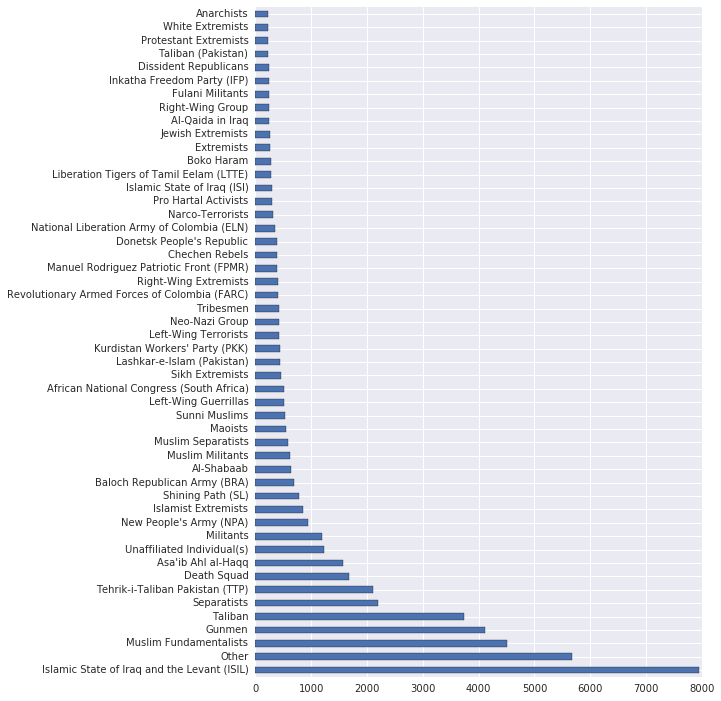

In [27]:
# incidents count by predicted terror groups
print sum(flag)
print predict_data['gname_predict'].value_counts().size
predict_data['gname_predict'].value_counts()[:50].plot(kind='barh')

## End of Work